In [1]:
# -*- coding: utf-8 -*-

import sys,os
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import linalg
from numpy import dot
import geomloss as gs

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import grad
import torch.utils.data
import torch.backends.cudnn as cudnn
from torch.nn.modules import Linear
from torch.autograd.functional import jacobian,hessian,vjp,vhp,hvp

import random
import math

FilePath = "../../"
file_list = ['GSM1599494_ES_d0_main.csv', 'GSM1599497_ES_d2_LIFminus.csv', 'GSM1599498_ES_d4_LIFminus.csv', 'GSM1599499_ES_d7_LIFminus.csv']

table_list = []
for filein in file_list:
    table_list.append(pd.read_csv(FilePath+filein, header=None))

matrix_list = []
gene_names = table_list[0].values[:,0]
for table in table_list:
    matrix_list.append(table.values[:,1:].astype('float32'))

cell_counts = [matrix.shape[1] for matrix in matrix_list]

# normalization
def normalize_run(mat):
    rpm = np.sum(mat,0)/1e6
    detect_pr = np.sum(mat==0,0)/float(mat.shape[0])
    return np.log(mat*(np.median(detect_pr)/detect_pr)*1.0/rpm + 1.0)

norm_mat = [normalize_run(matrix) for matrix in matrix_list]

# order by Wasserstein distance
qt_mat = [np.percentile(norm_in,q=np.linspace(0,100,50),axis=1) for norm_in in norm_mat] 
wdiv=np.sum((qt_mat[0]-qt_mat[3])**2,0)
w_order = np.argsort(-wdiv)

wsub = w_order[0:100]

def nmf(X, latent_features, max_iter=100, error_limit=1e-6, fit_error_limit=1e-6, print_iter=200):
    """
    Decompose X to A*Y
    """
    eps = 1e-5
    print('Starting NMF decomposition with {} latent features and {} iterations.'.format(latent_features, max_iter))
    #X = X.toarray()   I am passing in a scipy sparse matrix

    # mask
    mask = np.sign(X)

    # initial matrices. A is random [0,1] and Y is A\X.
    rows, columns = X.shape
    A = np.random.rand(rows, latent_features) 
    A = np.maximum(A, eps)

    Y = linalg.lstsq(A, X)[0]
    Y = np.maximum(Y, eps)

    masked_X = mask * X
    X_est_prev = dot(A, Y)
    for i in range(1, max_iter + 1):
        # ===== updates =====
        # Matlab: A=A.*(((W.*X)*Y')./((W.*(A*Y))*Y'));
        top = dot(masked_X, Y.T)
        bottom = (dot((mask * dot(A, Y)), Y.T)) + eps
        A *= top / bottom

        A = np.maximum(A, eps)
        # print 'A',  np.round(A, 2)

        # Matlab: Y=Y.*((A'*(W.*X))./(A'*(W.*(A*Y))));
        top = dot(A.T, masked_X)
        bottom = dot(A.T, mask * dot(A, Y)) + eps
        Y *= top / bottom
        Y = np.maximum(Y, eps)
        # print 'Y', np.round(Y, 2)


        # ==== evaluation ====
        if i % print_iter == 0 or i == 1 or i == max_iter:
            print('Iteration {}:'.format(i),)
            X_est = dot(A, Y)
            err = mask * (X_est_prev - X_est)
            fit_residual = np.sqrt(np.sum(err ** 2))
            X_est_prev = X_est

            curRes = linalg.norm(mask * (X - X_est), ord='fro')
            print('fit residual', np.round(fit_residual, 4),)
            print('total residual', np.round(curRes, 4))
            if curRes < error_limit or fit_residual < fit_error_limit:
                break
    return A, Y, dot(A,Y)

np.random.seed(0)
norm_imputed = [nmf(normin[wsub,:], latent_features = len(wsub)*4, max_iter=500)[2] for normin in norm_mat]

norm_adj = np.mean(norm_imputed[3],1)[:,np.newaxis]
subvec = np.array([0,1,2,3,4,5,6,7,8,9]) ## the top ten genes

gnvec = gene_names[w_order[subvec]]

cov_mat = np.cov(norm_imputed[3][subvec,:])
whiten = np.diag(np.diag(cov_mat)**(-0.5))
unwhiten = np.diag(np.diag(cov_mat)**(0.5))

norm_imputed2 = [np.dot(whiten,(normin - norm_adj)[subvec,:]) for normin in norm_imputed]

Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 4000.1233
total residual 138.7959
Iteration 200:
fit residual 123.6643
total residual 31.8464
Iteration 400:
fit residual 21.7894
total residual 12.6115
Iteration 500:
fit residual 4.3442
total residual 8.6686
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 2257.8358
total residual 58.2265
Iteration 200:
fit residual 56.8198
total residual 4.0447
Iteration 400:
fit residual 3.4777
total residual 0.6841
Iteration 500:
fit residual 0.3744
total residual 0.3185
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 2925.3664
total residual 80.2657
Iteration 200:
fit residual 78.1148
total residual 6.1559
Iteration 400:
fit residual 5.1661
total residual 1.1917
Iteration 500:
fit residual 0.6183
total residual 0.5917
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
f

In [2]:
def setup_seed(seed):
     torch.cuda.manual_seed(seed)
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.benchmark=False
     torch.backends.cudnn.deterministic = True
setup_seed(80)

class MLP(nn.Module):

    def __init__(self, dim_in, dim_out, dim_hidden=64, num_hidden=0, activation=nn.Tanh()):
        super(MLP, self).__init__()

        if num_hidden == 0:
            self.linears = nn.ModuleList([nn.Linear(dim_in, dim_out)])
        elif num_hidden >= 1:
            self.linears = nn.ModuleList() 
            self.linears.append(nn.Linear(dim_in, dim_hidden))
            self.linears.extend([nn.Linear(dim_hidden, dim_hidden) for _ in range(num_hidden-1)])
            self.linears.append(nn.Linear(dim_hidden, dim_out))
        else:
            raise Exception('number of hidden layers must be positive')

        for m in self.linears:
            nn.init.xavier_normal_(m.weight)
            nn.init.uniform_(m.bias,a=-0.1,b=0.1)
 
        self.activation = activation

    def forward(self, x):
        for m in self.linears[:-1]:
            x = self.activation(m(x))

        return self.linears[-1](x)
    
def compute_gradient_penalty(D, real_sample, fake_sample,k,p):
    real_samples = real_sample.requires_grad_(True)
    fake_samples = fake_sample.requires_grad_(True)

    real_validity = D(real_samples)
    fake_validity = D(fake_samples)

    real_grad_out = torch.ones((real_samples.shape[0],1),dtype=torch.float32,requires_grad=False,device="cuda")
    real_grad = grad(
        real_validity, real_samples, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

    fake_grad_out = torch.ones((fake_samples.shape[0],1),dtype=torch.float32,requires_grad=False,device="cuda")
    fake_grad = grad(
        fake_validity, fake_samples, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

    return (torch.sum(real_grad_norm) + torch.sum(fake_grad_norm)) * k / (real_sample.shape[0]+fake_sample.shape[0])

# generator
class JumpEulerForwardCuda(nn.Module):
    def __init__(self,in_features,num_hidden,dim_hidden,step_size):
        super(JumpEulerForwardCuda,self).__init__()

        self.drift = MLP(in_features,in_features,dim_hidden,num_hidden)
        self.diffusion = nn.Parameter(torch.ones(1))
        self.in_features = in_features
        self.step_size = step_size

    def forward(self,z0,Nsim,steps):

        PopulationPath = torch.empty(size = (Nsim,steps+1,self.in_features),device="cuda")
        PopulationPath[:,0,:] = z0
        state = z0

        for i in range(1,steps+1):
            state = state + self.drift(state)*self.step_size + math.sqrt(self.step_size)*torch.normal(0,1,size=(Nsim,self.in_features),device="cuda")*self.diffusion
            PopulationPath[:,i,:] = state
        return PopulationPath

In [3]:
# training data
train_data = norm_imputed2

train0 = torch.tensor(train_data[0],dtype=torch.float32,requires_grad = True,device="cuda").t()
train2 = torch.tensor(train_data[1],dtype=torch.float32,requires_grad = True,device="cuda").t()
train4 = torch.tensor(train_data[2],dtype=torch.float32,requires_grad = True,device="cuda").t()
train7 = torch.tensor(train_data[3],dtype=torch.float32,requires_grad = True,device="cuda").t()

n_sims = train0.shape[0]
in_features = train0.shape[1]

### hyperparameters
n_steps = [10,35]
step_size = 0.05
lr = 0.0002
k = 2
p = 6
num_hidden = 3
dim_hidden = 64

# create generator and critic
netG = JumpEulerForwardCuda(10,num_hidden,dim_hidden,step_size).cuda()
netD1 = MLP(10,1,dim_hidden,num_hidden).cuda()
netD2 = MLP(10,1,dim_hidden,num_hidden).cuda()


optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerSD1 = optim.Adam(netD1.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerSD2 = optim.Adam(netD2.parameters(), lr=lr, betas=(0.5, 0.999))

In [4]:
a = gs.SamplesLoss(loss='sinkhorn',p=2,blur=0.01)

In [5]:
n_epochs = 30000
for epoch in range(n_epochs):
  
    
    # -------------------
    # train the critic
    # -------------------
    


    for _ in range(4): 
        fake_data = netG(train0,n_sims,n_steps[1])
        fake1 = fake_data[:,n_steps[0],:]
        fake2 = fake_data[:,n_steps[1],:]

        optimizerSD1.zero_grad()

        div_gp1 = compute_gradient_penalty(netD1,train2,fake1,k,p)
        d1_loss = -torch.mean(netD1(train2))+torch.mean(netD1(fake1))+div_gp1
        d1_loss.backward(retain_graph=True) # retain_graph=True

        optimizerSD1.step()

        optimizerSD2.zero_grad()
        
        div_gp2 = compute_gradient_penalty(netD2,train7,fake2,k,p)
        d2_loss = -torch.mean(netD2(train7))+torch.mean(netD2(fake2))+div_gp2
        d2_loss.backward(retain_graph=True)

        optimizerSD2.step()
        


    # ----------------
    # train the generator
    # ----------------

    
    for _ in range(1):
        optimizerG.zero_grad()
        
        fake_data = netG(train0,n_sims,n_steps[1])
        fake1 = fake_data[:,n_steps[0],:]
        fake2 = fake_data[:,n_steps[1],:]
        g_loss = -torch.mean(netD1(fake1))-torch.mean(netD2(fake2))
        g_loss.backward() 

        optimizerG.step()

    if epoch %10==0:
        print("epoch:",epoch,";", "d1_loss:",(-d1_loss+div_gp1).item(),";","d2_loss:",(-d2_loss+div_gp2).item(),";","g_loss:",g_loss.item())
        print("epoch: ",epoch,"training1: ",a(fake_data[:,n_steps[0],:],train2).item(),"training2: ",a(fake_data[:,n_steps[1],:],train7).item())

epoch: 0 ; d1_loss: 0.11461840569972992 ; d2_loss: 1.0943284034729004 ; g_loss: 1.26871919631958
epoch:  0 training1:  8.571830749511719 training2:  91.94915008544922
epoch: 10 ; d1_loss: 1.5475577116012573 ; d2_loss: 4.5038557052612305 ; g_loss: 5.443056106567383
epoch:  10 training1:  7.951704025268555 training2:  85.72599792480469
epoch: 20 ; d1_loss: 1.5476024150848389 ; d2_loss: 5.710193157196045 ; g_loss: 5.680412292480469
epoch:  20 training1:  6.062077045440674 training2:  65.78924560546875
epoch: 30 ; d1_loss: 1.3886371850967407 ; d2_loss: 6.036042213439941 ; g_loss: 4.760902404785156
epoch:  30 training1:  4.82851505279541 training2:  46.416664123535156
epoch: 40 ; d1_loss: 1.4141192436218262 ; d2_loss: 5.415505409240723 ; g_loss: 3.401214838027954
epoch:  40 training1:  4.345595836639404 training2:  30.84381866455078
epoch: 50 ; d1_loss: 1.4389333724975586 ; d2_loss: 4.148115158081055 ; g_loss: 1.6480965614318848
epoch:  50 training1:  4.50862455368042 training2:  19.3855018

epoch: 480 ; d1_loss: 0.937250018119812 ; d2_loss: 0.6278433799743652 ; g_loss: -3.6581802368164062
epoch:  480 training1:  2.625380516052246 training2:  2.2788808345794678
epoch: 490 ; d1_loss: 0.8842606544494629 ; d2_loss: 0.639068603515625 ; g_loss: -3.6073434352874756
epoch:  490 training1:  2.522174835205078 training2:  2.2435097694396973
epoch: 500 ; d1_loss: 0.8540070056915283 ; d2_loss: 0.5853362083435059 ; g_loss: -3.5253405570983887
epoch:  500 training1:  2.494600772857666 training2:  2.174403190612793
epoch: 510 ; d1_loss: 0.8625301122665405 ; d2_loss: 0.6012735366821289 ; g_loss: -3.511223316192627
epoch:  510 training1:  2.46103835105896 training2:  2.110334634780884
epoch: 520 ; d1_loss: 0.8429585695266724 ; d2_loss: 0.5745260715484619 ; g_loss: -3.3667335510253906
epoch:  520 training1:  2.4079642295837402 training2:  2.065768241882324
epoch: 530 ; d1_loss: 0.8166157007217407 ; d2_loss: 0.55729079246521 ; g_loss: -3.2931108474731445
epoch:  530 training1:  2.39769744873

epoch: 960 ; d1_loss: 0.703889787197113 ; d2_loss: 0.39710718393325806 ; g_loss: -1.3595352172851562
epoch:  960 training1:  1.8772345781326294 training2:  1.5351676940917969
epoch: 970 ; d1_loss: 0.6979227066040039 ; d2_loss: 0.3621669411659241 ; g_loss: -1.3494970798492432
epoch:  970 training1:  1.7917060852050781 training2:  1.5336620807647705
epoch: 980 ; d1_loss: 0.6825315356254578 ; d2_loss: 0.35906511545181274 ; g_loss: -1.3816123008728027
epoch:  980 training1:  1.8215241432189941 training2:  1.4532686471939087
epoch: 990 ; d1_loss: 0.6953005790710449 ; d2_loss: 0.34848541021347046 ; g_loss: -1.355593204498291
epoch:  990 training1:  1.8184804916381836 training2:  1.4926339387893677
epoch: 1000 ; d1_loss: 0.6837806105613708 ; d2_loss: 0.3686153292655945 ; g_loss: -1.2997539043426514
epoch:  1000 training1:  1.7934225797653198 training2:  1.5380537509918213
epoch: 1010 ; d1_loss: 0.6877903342247009 ; d2_loss: 0.3760766386985779 ; g_loss: -1.3186510801315308
epoch:  1010 trainin

epoch: 1430 ; d1_loss: 0.6093859076499939 ; d2_loss: 0.3338964283466339 ; g_loss: -1.4627848863601685
epoch:  1430 training1:  1.6544568538665771 training2:  1.4519686698913574
epoch: 1440 ; d1_loss: 0.6300790905952454 ; d2_loss: 0.33195561170578003 ; g_loss: -1.5030560493469238
epoch:  1440 training1:  1.6286617517471313 training2:  1.4350135326385498
epoch: 1450 ; d1_loss: 0.6205049753189087 ; d2_loss: 0.3638065755367279 ; g_loss: -1.3325103521347046
epoch:  1450 training1:  1.672509789466858 training2:  1.485887050628662
epoch: 1460 ; d1_loss: 0.6287409663200378 ; d2_loss: 0.35176730155944824 ; g_loss: -1.3370420932769775
epoch:  1460 training1:  1.6241114139556885 training2:  1.4519363641738892
epoch: 1470 ; d1_loss: 0.6261787414550781 ; d2_loss: 0.35311394929885864 ; g_loss: -1.2813725471496582
epoch:  1470 training1:  1.6349759101867676 training2:  1.4538753032684326
epoch: 1480 ; d1_loss: 0.6233198642730713 ; d2_loss: 0.3453610837459564 ; g_loss: -1.2558917999267578
epoch:  1480

epoch: 1900 ; d1_loss: 0.6048222780227661 ; d2_loss: 0.35871773958206177 ; g_loss: -1.288771390914917
epoch:  1900 training1:  1.5136501789093018 training2:  1.4284651279449463
epoch: 1910 ; d1_loss: 0.5788822174072266 ; d2_loss: 0.3531491160392761 ; g_loss: -0.9416276216506958
epoch:  1910 training1:  1.5325653553009033 training2:  1.4800074100494385
epoch: 1920 ; d1_loss: 0.5921468734741211 ; d2_loss: 0.3655319809913635 ; g_loss: -0.853356122970581
epoch:  1920 training1:  1.5515923500061035 training2:  1.3739441633224487
epoch: 1930 ; d1_loss: 0.6086768507957458 ; d2_loss: 0.36228495836257935 ; g_loss: -0.9815233945846558
epoch:  1930 training1:  1.5196118354797363 training2:  1.4309748411178589
epoch: 1940 ; d1_loss: 0.6049816608428955 ; d2_loss: 0.36144816875457764 ; g_loss: -0.935682475566864
epoch:  1940 training1:  1.5176674127578735 training2:  1.420682668685913
epoch: 1950 ; d1_loss: 0.6061009168624878 ; d2_loss: 0.35224437713623047 ; g_loss: -0.9104369878768921
epoch:  1950 

epoch: 2370 ; d1_loss: 0.5493978261947632 ; d2_loss: 0.37680894136428833 ; g_loss: 0.17186075448989868
epoch:  2370 training1:  1.4039421081542969 training2:  1.4112088680267334
epoch: 2380 ; d1_loss: 0.6007546186447144 ; d2_loss: 0.3678259253501892 ; g_loss: -0.25028195977211
epoch:  2380 training1:  1.4288980960845947 training2:  1.3946822881698608
epoch: 2390 ; d1_loss: 0.5878005623817444 ; d2_loss: 0.3761753439903259 ; g_loss: -0.2425076961517334
epoch:  2390 training1:  1.3702023029327393 training2:  1.384356141090393
epoch: 2400 ; d1_loss: 0.602348268032074 ; d2_loss: 0.3733861446380615 ; g_loss: -0.2603829503059387
epoch:  2400 training1:  1.4110549688339233 training2:  1.371390700340271
epoch: 2410 ; d1_loss: 0.6036181449890137 ; d2_loss: 0.37424254417419434 ; g_loss: -0.4409680664539337
epoch:  2410 training1:  1.4063918590545654 training2:  1.3537917137145996
epoch: 2420 ; d1_loss: 0.5897682905197144 ; d2_loss: 0.36087775230407715 ; g_loss: -0.07471948862075806
epoch:  2420 t

epoch: 2840 ; d1_loss: 0.5807270407676697 ; d2_loss: 0.3724072575569153 ; g_loss: 0.621234655380249
epoch:  2840 training1:  1.3479722738265991 training2:  1.3696975708007812
epoch: 2850 ; d1_loss: 0.5821835398674011 ; d2_loss: 0.3830150365829468 ; g_loss: 0.7270188927650452
epoch:  2850 training1:  1.3323360681533813 training2:  1.3464034795761108
epoch: 2860 ; d1_loss: 0.5790929198265076 ; d2_loss: 0.3772020936012268 ; g_loss: 0.6288659572601318
epoch:  2860 training1:  1.3625411987304688 training2:  1.3557217121124268
epoch: 2870 ; d1_loss: 0.5853299498558044 ; d2_loss: 0.37791329622268677 ; g_loss: 0.6832773685455322
epoch:  2870 training1:  1.3073399066925049 training2:  1.30938720703125
epoch: 2880 ; d1_loss: 0.5874149203300476 ; d2_loss: 0.3876805305480957 ; g_loss: 0.6995882391929626
epoch:  2880 training1:  1.3106173276901245 training2:  1.3960174322128296
epoch: 2890 ; d1_loss: 0.5761064291000366 ; d2_loss: 0.37825262546539307 ; g_loss: 0.6527820229530334
epoch:  2890 trainin

epoch: 3310 ; d1_loss: 0.41040360927581787 ; d2_loss: 0.40433400869369507 ; g_loss: 1.1254080533981323
epoch:  3310 training1:  1.3308645486831665 training2:  1.3491294384002686
epoch: 3320 ; d1_loss: 0.41773736476898193 ; d2_loss: 0.41431623697280884 ; g_loss: 1.0920085906982422
epoch:  3320 training1:  1.3036785125732422 training2:  1.3516411781311035
epoch: 3330 ; d1_loss: 0.4236041307449341 ; d2_loss: 0.38666898012161255 ; g_loss: 1.2366433143615723
epoch:  3330 training1:  1.2766239643096924 training2:  1.3049551248550415
epoch: 3340 ; d1_loss: 0.4286203384399414 ; d2_loss: 0.40764120221138 ; g_loss: 1.1925780773162842
epoch:  3340 training1:  1.2967091798782349 training2:  1.3031907081604004
epoch: 3350 ; d1_loss: 0.4304715394973755 ; d2_loss: 0.4008936285972595 ; g_loss: 1.1366705894470215
epoch:  3350 training1:  1.268057942390442 training2:  1.309826374053955
epoch: 3360 ; d1_loss: 0.43940865993499756 ; d2_loss: 0.39322641491889954 ; g_loss: 1.1995218992233276
epoch:  3360 tra

epoch: 3780 ; d1_loss: 0.4962904453277588 ; d2_loss: 0.42112255096435547 ; g_loss: 1.2405219078063965
epoch:  3780 training1:  1.20542573928833 training2:  1.316821575164795
epoch: 3790 ; d1_loss: 0.5092042684555054 ; d2_loss: 0.4073542356491089 ; g_loss: 1.0953876972198486
epoch:  3790 training1:  1.2343465089797974 training2:  1.319615125656128
epoch: 3800 ; d1_loss: 0.5082833766937256 ; d2_loss: 0.4073387384414673 ; g_loss: 1.1250648498535156
epoch:  3800 training1:  1.2676185369491577 training2:  1.3295879364013672
epoch: 3810 ; d1_loss: 0.4998750686645508 ; d2_loss: 0.4216634929180145 ; g_loss: 1.170133352279663
epoch:  3810 training1:  1.2449804544448853 training2:  1.3176662921905518
epoch: 3820 ; d1_loss: 0.5091511011123657 ; d2_loss: 0.4239721894264221 ; g_loss: 1.1720054149627686
epoch:  3820 training1:  1.231289267539978 training2:  1.355075478553772
epoch: 3830 ; d1_loss: 0.5108287334442139 ; d2_loss: 0.4064599871635437 ; g_loss: 1.1334706544876099
epoch:  3830 training1:  

epoch: 4250 ; d1_loss: 0.5216537714004517 ; d2_loss: 0.44519877433776855 ; g_loss: 1.6633946895599365
epoch:  4250 training1:  1.1778063774108887 training2:  1.3028640747070312
epoch: 4260 ; d1_loss: 0.5272903442382812 ; d2_loss: 0.426754891872406 ; g_loss: 1.5530264377593994
epoch:  4260 training1:  1.211529016494751 training2:  1.285038709640503
epoch: 4270 ; d1_loss: 0.5254712104797363 ; d2_loss: 0.41666120290756226 ; g_loss: 1.6214267015457153
epoch:  4270 training1:  1.18179452419281 training2:  1.3152005672454834
epoch: 4280 ; d1_loss: 0.5406366586685181 ; d2_loss: 0.42120665311813354 ; g_loss: 1.5826822519302368
epoch:  4280 training1:  1.1906111240386963 training2:  1.3533838987350464
epoch: 4290 ; d1_loss: 0.5346682071685791 ; d2_loss: 0.40613222122192383 ; g_loss: 1.5805675983428955
epoch:  4290 training1:  1.2206087112426758 training2:  1.303208589553833
epoch: 4300 ; d1_loss: 0.5393874645233154 ; d2_loss: 0.42105549573898315 ; g_loss: 1.4871127605438232
epoch:  4300 trainin

epoch: 4720 ; d1_loss: 0.5667756795883179 ; d2_loss: 0.42156216502189636 ; g_loss: 2.015261650085449
epoch:  4720 training1:  1.154120922088623 training2:  1.3137552738189697
epoch: 4730 ; d1_loss: 0.5720995664596558 ; d2_loss: 0.4236152172088623 ; g_loss: 1.9742481708526611
epoch:  4730 training1:  1.1821812391281128 training2:  1.277323842048645
epoch: 4740 ; d1_loss: 0.5653290748596191 ; d2_loss: 0.42697182297706604 ; g_loss: 1.954972505569458
epoch:  4740 training1:  1.1696059703826904 training2:  1.2947242259979248
epoch: 4750 ; d1_loss: 0.565568208694458 ; d2_loss: 0.42608046531677246 ; g_loss: 1.9553909301757812
epoch:  4750 training1:  1.1457942724227905 training2:  1.2771053314208984
epoch: 4760 ; d1_loss: 0.5731264352798462 ; d2_loss: 0.42497822642326355 ; g_loss: 2.1645660400390625
epoch:  4760 training1:  1.1749968528747559 training2:  1.2650995254516602
epoch: 4770 ; d1_loss: 0.5696192979812622 ; d2_loss: 0.4313812255859375 ; g_loss: 1.990795373916626
epoch:  4770 training

epoch: 5190 ; d1_loss: 0.3974580764770508 ; d2_loss: 0.44078826904296875 ; g_loss: 0.9967429041862488
epoch:  5190 training1:  1.1660274267196655 training2:  1.268710970878601
epoch: 5200 ; d1_loss: 0.4449450969696045 ; d2_loss: 0.43475034832954407 ; g_loss: 2.0471489429473877
epoch:  5200 training1:  1.213559865951538 training2:  1.2705576419830322
epoch: 5210 ; d1_loss: 0.47560179233551025 ; d2_loss: 0.4418885111808777 ; g_loss: 2.1064822673797607
epoch:  5210 training1:  1.1653417348861694 training2:  1.25130295753479
epoch: 5220 ; d1_loss: 0.4873915910720825 ; d2_loss: 0.4295157790184021 ; g_loss: 2.082763671875
epoch:  5220 training1:  1.1382519006729126 training2:  1.2546160221099854
epoch: 5230 ; d1_loss: 0.5049493312835693 ; d2_loss: 0.43667152523994446 ; g_loss: 2.1382064819335938
epoch:  5230 training1:  1.128690481185913 training2:  1.2694706916809082
epoch: 5240 ; d1_loss: 0.5140155553817749 ; d2_loss: 0.4512897729873657 ; g_loss: 2.042806625366211
epoch:  5240 training1:  

epoch: 5660 ; d1_loss: 0.5255693197250366 ; d2_loss: 0.4387242794036865 ; g_loss: 2.1323907375335693
epoch:  5660 training1:  1.161419153213501 training2:  1.2743253707885742
epoch: 5670 ; d1_loss: 0.5242675542831421 ; d2_loss: 0.44330763816833496 ; g_loss: 2.0481464862823486
epoch:  5670 training1:  1.1602970361709595 training2:  1.2648546695709229
epoch: 5680 ; d1_loss: 0.5229108333587646 ; d2_loss: 0.44192540645599365 ; g_loss: 2.07914137840271
epoch:  5680 training1:  1.1472550630569458 training2:  1.2681665420532227
epoch: 5690 ; d1_loss: 0.5283055305480957 ; d2_loss: 0.45664167404174805 ; g_loss: 2.0912187099456787
epoch:  5690 training1:  1.1675763130187988 training2:  1.2874585390090942
epoch: 5700 ; d1_loss: 0.5299396514892578 ; d2_loss: 0.4455445408821106 ; g_loss: 2.166295051574707
epoch:  5700 training1:  1.1426913738250732 training2:  1.257784366607666
epoch: 5710 ; d1_loss: 0.5313174724578857 ; d2_loss: 0.4425349235534668 ; g_loss: 2.133190393447876
epoch:  5710 training1

epoch: 6130 ; d1_loss: 0.5704972743988037 ; d2_loss: 0.4512178599834442 ; g_loss: 2.5397486686706543
epoch:  6130 training1:  1.1209416389465332 training2:  1.2525075674057007
epoch: 6140 ; d1_loss: 0.5698208808898926 ; d2_loss: 0.4582436680793762 ; g_loss: 2.5986311435699463
epoch:  6140 training1:  1.1240757703781128 training2:  1.2720766067504883
epoch: 6150 ; d1_loss: 0.5803203582763672 ; d2_loss: 0.44476282596588135 ; g_loss: 2.548072338104248
epoch:  6150 training1:  1.1509969234466553 training2:  1.261733889579773
epoch: 6160 ; d1_loss: 0.5627906322479248 ; d2_loss: 0.46201759576797485 ; g_loss: 2.559560537338257
epoch:  6160 training1:  1.1384307146072388 training2:  1.2766194343566895
epoch: 6170 ; d1_loss: 0.5646193027496338 ; d2_loss: 0.44799506664276123 ; g_loss: 2.5608088970184326
epoch:  6170 training1:  1.134382724761963 training2:  1.2401524782180786
epoch: 6180 ; d1_loss: 0.5687212944030762 ; d2_loss: 0.4579222798347473 ; g_loss: 2.557889461517334
epoch:  6180 training

epoch: 6600 ; d1_loss: 0.5449111461639404 ; d2_loss: 0.4619385004043579 ; g_loss: 2.4680354595184326
epoch:  6600 training1:  1.1040335893630981 training2:  1.2312109470367432
epoch: 6610 ; d1_loss: 0.5467104911804199 ; d2_loss: 0.4622541666030884 ; g_loss: 2.5209834575653076
epoch:  6610 training1:  1.1269351243972778 training2:  1.2529613971710205
epoch: 6620 ; d1_loss: 0.5425882339477539 ; d2_loss: 0.4773038923740387 ; g_loss: 2.5371110439300537
epoch:  6620 training1:  1.128699541091919 training2:  1.2640902996063232
epoch: 6630 ; d1_loss: 0.5456221103668213 ; d2_loss: 0.4579872786998749 ; g_loss: 2.5063693523406982
epoch:  6630 training1:  1.138987421989441 training2:  1.2116481065750122
epoch: 6640 ; d1_loss: 0.5493068695068359 ; d2_loss: 0.45836764574050903 ; g_loss: 2.5189030170440674
epoch:  6640 training1:  1.146301507949829 training2:  1.2141128778457642
epoch: 6650 ; d1_loss: 0.5543045997619629 ; d2_loss: 0.46411019563674927 ; g_loss: 2.563366174697876
epoch:  6650 training

epoch: 7070 ; d1_loss: 0.4696972370147705 ; d2_loss: 0.47450265288352966 ; g_loss: 2.3688485622406006
epoch:  7070 training1:  1.1116394996643066 training2:  1.2306021451950073
epoch: 7080 ; d1_loss: 0.47075963020324707 ; d2_loss: 0.4809424877166748 ; g_loss: 2.3671624660491943
epoch:  7080 training1:  1.1321823596954346 training2:  1.2632642984390259
epoch: 7090 ; d1_loss: 0.47742438316345215 ; d2_loss: 0.46211159229278564 ; g_loss: 2.423851251602173
epoch:  7090 training1:  1.1256400346755981 training2:  1.2287431955337524
epoch: 7100 ; d1_loss: 0.47805356979370117 ; d2_loss: 0.4792528450489044 ; g_loss: 2.455134391784668
epoch:  7100 training1:  1.1399145126342773 training2:  1.2426880598068237
epoch: 7110 ; d1_loss: 0.48511219024658203 ; d2_loss: 0.47628140449523926 ; g_loss: 2.430051803588867
epoch:  7110 training1:  1.110788345336914 training2:  1.2246538400650024
epoch: 7120 ; d1_loss: 0.48116469383239746 ; d2_loss: 0.48573046922683716 ; g_loss: 2.4617714881896973
epoch:  7120 t

epoch: 7540 ; d1_loss: 0.5502877235412598 ; d2_loss: 0.4792253077030182 ; g_loss: 2.84867787361145
epoch:  7540 training1:  1.1258587837219238 training2:  1.2209203243255615
epoch: 7550 ; d1_loss: 0.5507495403289795 ; d2_loss: 0.4786217510700226 ; g_loss: 2.7821364402770996
epoch:  7550 training1:  1.109790563583374 training2:  1.217435598373413
epoch: 7560 ; d1_loss: 0.5549328327178955 ; d2_loss: 0.4755845069885254 ; g_loss: 2.8773066997528076
epoch:  7560 training1:  1.1248397827148438 training2:  1.242971658706665
epoch: 7570 ; d1_loss: 0.5568928718566895 ; d2_loss: 0.4782576560974121 ; g_loss: 2.9111616611480713
epoch:  7570 training1:  1.134291648864746 training2:  1.2436177730560303
epoch: 7580 ; d1_loss: 0.557074785232544 ; d2_loss: 0.4969126582145691 ; g_loss: 2.9784133434295654
epoch:  7580 training1:  1.1201016902923584 training2:  1.2620728015899658
epoch: 7590 ; d1_loss: 0.5651514530181885 ; d2_loss: 0.4827965795993805 ; g_loss: 2.8600122928619385
epoch:  7590 training1:  1

epoch: 8010 ; d1_loss: 0.6017282009124756 ; d2_loss: 0.4868429899215698 ; g_loss: 3.4711368083953857
epoch:  8010 training1:  1.1036688089370728 training2:  1.226114273071289
epoch: 8020 ; d1_loss: 0.6054916381835938 ; d2_loss: 0.4978565275669098 ; g_loss: 3.607771158218384
epoch:  8020 training1:  1.1073696613311768 training2:  1.209653615951538
epoch: 8030 ; d1_loss: 0.6021726131439209 ; d2_loss: 0.47567224502563477 ; g_loss: 3.492276668548584
epoch:  8030 training1:  1.0927459001541138 training2:  1.2156546115875244
epoch: 8040 ; d1_loss: 0.5959300994873047 ; d2_loss: 0.48249325156211853 ; g_loss: 3.5252685546875
epoch:  8040 training1:  1.1271470785140991 training2:  1.2274444103240967
epoch: 8050 ; d1_loss: 0.597100019454956 ; d2_loss: 0.5003633499145508 ; g_loss: 3.601053237915039
epoch:  8050 training1:  1.122467279434204 training2:  1.2337915897369385
epoch: 8060 ; d1_loss: 0.6096546649932861 ; d2_loss: 0.48594462871551514 ; g_loss: 3.563870906829834
epoch:  8060 training1:  1.

epoch: 8480 ; d1_loss: 0.3832681179046631 ; d2_loss: 0.5238243341445923 ; g_loss: 2.189826011657715
epoch:  8480 training1:  1.5667946338653564 training2:  1.268837571144104
epoch: 8490 ; d1_loss: 0.3711893558502197 ; d2_loss: 0.5165017247200012 ; g_loss: 2.2423436641693115
epoch:  8490 training1:  1.4998080730438232 training2:  1.2983256578445435
epoch: 8500 ; d1_loss: 0.37049221992492676 ; d2_loss: 0.5150169134140015 ; g_loss: 2.3052268028259277
epoch:  8500 training1:  1.4178833961486816 training2:  1.2658860683441162
epoch: 8510 ; d1_loss: 0.3889472484588623 ; d2_loss: 0.5177007913589478 ; g_loss: 2.368830442428589
epoch:  8510 training1:  1.3716166019439697 training2:  1.2780282497406006
epoch: 8520 ; d1_loss: 0.39566969871520996 ; d2_loss: 0.5187463760375977 ; g_loss: 2.3950071334838867
epoch:  8520 training1:  1.307269811630249 training2:  1.2721636295318604
epoch: 8530 ; d1_loss: 0.40041351318359375 ; d2_loss: 0.5266770720481873 ; g_loss: 2.482022523880005
epoch:  8530 training

epoch: 8950 ; d1_loss: 0.4775524139404297 ; d2_loss: 0.5069199800491333 ; g_loss: 3.066117763519287
epoch:  8950 training1:  1.0766582489013672 training2:  1.1794219017028809
epoch: 8960 ; d1_loss: 0.47606515884399414 ; d2_loss: 0.5002235770225525 ; g_loss: 3.0831451416015625
epoch:  8960 training1:  1.0998575687408447 training2:  1.19155752658844
epoch: 8970 ; d1_loss: 0.4822235107421875 ; d2_loss: 0.5082229971885681 ; g_loss: 3.0595712661743164
epoch:  8970 training1:  1.1120785474777222 training2:  1.182121992111206
epoch: 8980 ; d1_loss: 0.4774622917175293 ; d2_loss: 0.506506621837616 ; g_loss: 3.098346710205078
epoch:  8980 training1:  1.095240592956543 training2:  1.2276136875152588
epoch: 8990 ; d1_loss: 0.47767019271850586 ; d2_loss: 0.5191149711608887 ; g_loss: 3.126005172729492
epoch:  8990 training1:  1.1072807312011719 training2:  1.219429850578308
epoch: 9000 ; d1_loss: 0.4801449775695801 ; d2_loss: 0.508269190788269 ; g_loss: 3.13726806640625
epoch:  9000 training1:  1.09

epoch: 9420 ; d1_loss: 0.529552698135376 ; d2_loss: 0.5036975145339966 ; g_loss: 3.269710063934326
epoch:  9420 training1:  1.0663490295410156 training2:  1.2213337421417236
epoch: 9430 ; d1_loss: 0.527047872543335 ; d2_loss: 0.5036805272102356 ; g_loss: 3.2917802333831787
epoch:  9430 training1:  1.081387996673584 training2:  1.2084803581237793
epoch: 9440 ; d1_loss: 0.5310053825378418 ; d2_loss: 0.5186402201652527 ; g_loss: 3.3204925060272217
epoch:  9440 training1:  1.0928966999053955 training2:  1.21045982837677
epoch: 9450 ; d1_loss: 0.5237381458282471 ; d2_loss: 0.5083568096160889 ; g_loss: 3.289174795150757
epoch:  9450 training1:  1.1024343967437744 training2:  1.2258973121643066
epoch: 9460 ; d1_loss: 0.5316038131713867 ; d2_loss: 0.5167726278305054 ; g_loss: 3.3254592418670654
epoch:  9460 training1:  1.0886247158050537 training2:  1.1778441667556763
epoch: 9470 ; d1_loss: 0.5235812664031982 ; d2_loss: 0.5083571672439575 ; g_loss: 3.272369861602783
epoch:  9470 training1:  1.

epoch: 9890 ; d1_loss: 0.534862756729126 ; d2_loss: 0.5087761878967285 ; g_loss: 3.320878028869629
epoch:  9890 training1:  1.0931693315505981 training2:  1.21840500831604
epoch: 9900 ; d1_loss: 0.5376861095428467 ; d2_loss: 0.513149082660675 ; g_loss: 3.285966157913208
epoch:  9900 training1:  1.1112420558929443 training2:  1.1701829433441162
epoch: 9910 ; d1_loss: 0.5310862064361572 ; d2_loss: 0.519872784614563 ; g_loss: 3.2725090980529785
epoch:  9910 training1:  1.0908530950546265 training2:  1.1999938488006592
epoch: 9920 ; d1_loss: 0.5391390323638916 ; d2_loss: 0.5173598527908325 ; g_loss: 3.34220552444458
epoch:  9920 training1:  1.1056956052780151 training2:  1.2026841640472412
epoch: 9930 ; d1_loss: 0.5368814468383789 ; d2_loss: 0.512729823589325 ; g_loss: 3.306307554244995
epoch:  9930 training1:  1.086462140083313 training2:  1.1829251050949097
epoch: 9940 ; d1_loss: 0.537930965423584 ; d2_loss: 0.5152802467346191 ; g_loss: 3.338921070098877
epoch:  9940 training1:  1.092640

epoch: 10360 ; d1_loss: 0.5041337013244629 ; d2_loss: 0.5198121666908264 ; g_loss: 3.062623977661133
epoch:  10360 training1:  1.0735291242599487 training2:  1.181826114654541
epoch: 10370 ; d1_loss: 0.5099530220031738 ; d2_loss: 0.5199087858200073 ; g_loss: 3.201411247253418
epoch:  10370 training1:  1.0859596729278564 training2:  1.2116475105285645
epoch: 10380 ; d1_loss: 0.507399320602417 ; d2_loss: 0.5359195470809937 ; g_loss: 3.1856796741485596
epoch:  10380 training1:  1.0754623413085938 training2:  1.2199841737747192
epoch: 10390 ; d1_loss: 0.5090241432189941 ; d2_loss: 0.5126558542251587 ; g_loss: 3.138866662979126
epoch:  10390 training1:  1.0810816287994385 training2:  1.1894456148147583
epoch: 10400 ; d1_loss: 0.5140774250030518 ; d2_loss: 0.5118058919906616 ; g_loss: 3.135465383529663
epoch:  10400 training1:  1.070359468460083 training2:  1.182754635810852
epoch: 10410 ; d1_loss: 0.5096950531005859 ; d2_loss: 0.5259972810745239 ; g_loss: 3.062436819076538
epoch:  10410 tra

epoch: 10830 ; d1_loss: 0.5215051174163818 ; d2_loss: 0.5273118019104004 ; g_loss: 3.3418164253234863
epoch:  10830 training1:  1.0780017375946045 training2:  1.1889023780822754
epoch: 10840 ; d1_loss: 0.5316433906555176 ; d2_loss: 0.5124842524528503 ; g_loss: 3.296381711959839
epoch:  10840 training1:  1.0878446102142334 training2:  1.1696524620056152
epoch: 10850 ; d1_loss: 0.5359997749328613 ; d2_loss: 0.5264778137207031 ; g_loss: 3.3475422859191895
epoch:  10850 training1:  1.0556554794311523 training2:  1.190805196762085
epoch: 10860 ; d1_loss: 0.5348625183105469 ; d2_loss: 0.5282726883888245 ; g_loss: 3.3675639629364014
epoch:  10860 training1:  1.0657131671905518 training2:  1.1644337177276611
epoch: 10870 ; d1_loss: 0.5368094444274902 ; d2_loss: 0.5184549689292908 ; g_loss: 3.399552583694458
epoch:  10870 training1:  1.0736570358276367 training2:  1.193465232849121
epoch: 10880 ; d1_loss: 0.538862943649292 ; d2_loss: 0.5278714895248413 ; g_loss: 3.3968148231506348
epoch:  10880

epoch: 11300 ; d1_loss: 0.5963115692138672 ; d2_loss: 0.5388940572738647 ; g_loss: 4.070888996124268
epoch:  11300 training1:  1.0846714973449707 training2:  1.1811844110488892
epoch: 11310 ; d1_loss: 0.5991389751434326 ; d2_loss: 0.5275776982307434 ; g_loss: 4.138321399688721
epoch:  11310 training1:  1.058039903640747 training2:  1.1993942260742188
epoch: 11320 ; d1_loss: 0.5967833995819092 ; d2_loss: 0.5226577520370483 ; g_loss: 4.112208843231201
epoch:  11320 training1:  1.069288730621338 training2:  1.195905089378357
epoch: 11330 ; d1_loss: 0.593414306640625 ; d2_loss: 0.5299063920974731 ; g_loss: 4.207953929901123
epoch:  11330 training1:  1.0561593770980835 training2:  1.1779720783233643
epoch: 11340 ; d1_loss: 0.6021456718444824 ; d2_loss: 0.5311300754547119 ; g_loss: 4.161073684692383
epoch:  11340 training1:  1.0875816345214844 training2:  1.204110860824585
epoch: 11350 ; d1_loss: 0.5983052253723145 ; d2_loss: 0.545067548751831 ; g_loss: 4.159743785858154
epoch:  11350 traini

epoch: 11770 ; d1_loss: 0.6804037094116211 ; d2_loss: 0.5472506284713745 ; g_loss: 5.2221527099609375
epoch:  11770 training1:  1.0681252479553223 training2:  1.1753315925598145
epoch: 11780 ; d1_loss: 0.676628589630127 ; d2_loss: 0.5429360866546631 ; g_loss: 5.421076774597168
epoch:  11780 training1:  1.0597825050354004 training2:  1.1820335388183594
epoch: 11790 ; d1_loss: 0.6757712364196777 ; d2_loss: 0.5281157493591309 ; g_loss: 5.426456451416016
epoch:  11790 training1:  1.0602229833602905 training2:  1.1757612228393555
epoch: 11800 ; d1_loss: 0.6816449165344238 ; d2_loss: 0.5317192077636719 ; g_loss: 5.4111762046813965
epoch:  11800 training1:  1.054372787475586 training2:  1.1744846105575562
epoch: 11810 ; d1_loss: 0.6879520416259766 ; d2_loss: 0.5323173403739929 ; g_loss: 5.567723751068115
epoch:  11810 training1:  1.0591108798980713 training2:  1.1644911766052246
epoch: 11820 ; d1_loss: 0.6884236335754395 ; d2_loss: 0.5442785620689392 ; g_loss: 5.477151870727539
epoch:  11820 

epoch: 12240 ; d1_loss: -1.1680576801300049 ; d2_loss: 0.9137160181999207 ; g_loss: 1.0133863687515259
epoch:  12240 training1:  82.49406433105469 training2:  1.6989727020263672
epoch: 12250 ; d1_loss: -1.203801155090332 ; d2_loss: 0.9155918955802917 ; g_loss: 0.8763493895530701
epoch:  12250 training1:  86.47059631347656 training2:  1.6974904537200928
epoch: 12260 ; d1_loss: -1.2287812232971191 ; d2_loss: 0.9293709993362427 ; g_loss: 0.8242132663726807
epoch:  12260 training1:  90.53805541992188 training2:  1.7461822032928467
epoch: 12270 ; d1_loss: -1.2121062278747559 ; d2_loss: 0.9188072681427002 ; g_loss: 0.8301563858985901
epoch:  12270 training1:  94.26205444335938 training2:  1.7006525993347168
epoch: 12280 ; d1_loss: -1.1590516567230225 ; d2_loss: 0.9374300837516785 ; g_loss: 0.8496806621551514
epoch:  12280 training1:  97.95146179199219 training2:  1.736986756324768
epoch: 12290 ; d1_loss: -1.1104040145874023 ; d2_loss: 0.9308699369430542 ; g_loss: 0.8967270255088806
epoch:  1

epoch: 12710 ; d1_loss: 4.065823554992676 ; d2_loss: 0.919488787651062 ; g_loss: 4.00921630859375
epoch:  12710 training1:  155.88003540039062 training2:  1.58353853225708
epoch: 12720 ; d1_loss: 4.276996612548828 ; d2_loss: 0.8957830667495728 ; g_loss: 4.113215923309326
epoch:  12720 training1:  157.3270263671875 training2:  1.5713136196136475
epoch: 12730 ; d1_loss: 4.483593940734863 ; d2_loss: 0.9071559906005859 ; g_loss: 4.251179218292236
epoch:  12730 training1:  159.013427734375 training2:  1.6004059314727783
epoch: 12740 ; d1_loss: 4.646299839019775 ; d2_loss: 0.890590488910675 ; g_loss: 4.2139811515808105
epoch:  12740 training1:  160.1162109375 training2:  1.5550787448883057
epoch: 12750 ; d1_loss: 4.83624267578125 ; d2_loss: 0.8804444074630737 ; g_loss: 4.401146411895752
epoch:  12750 training1:  161.62014770507812 training2:  1.5809335708618164
epoch: 12760 ; d1_loss: 5.045952796936035 ; d2_loss: 0.8782317638397217 ; g_loss: 4.544228553771973
epoch:  12760 training1:  162.77

epoch: 13180 ; d1_loss: 2.137659788131714 ; d2_loss: 1.0464484691619873 ; g_loss: 1.8667688369750977
epoch:  13180 training1:  11.08356761932373 training2:  1.7949516773223877
epoch: 13190 ; d1_loss: 2.2103583812713623 ; d2_loss: 1.036880373954773 ; g_loss: 1.974664568901062
epoch:  13190 training1:  12.345499992370605 training2:  1.7564440965652466
epoch: 13200 ; d1_loss: 2.3203389644622803 ; d2_loss: 0.999407947063446 ; g_loss: 1.9969817399978638
epoch:  13200 training1:  13.670147895812988 training2:  1.7105849981307983
epoch: 13210 ; d1_loss: 2.4488391876220703 ; d2_loss: 0.9923954010009766 ; g_loss: 2.0880560874938965
epoch:  13210 training1:  14.60842514038086 training2:  1.6722521781921387
epoch: 13220 ; d1_loss: 2.565603256225586 ; d2_loss: 1.0134408473968506 ; g_loss: 2.1680333614349365
epoch:  13220 training1:  14.992303848266602 training2:  1.7109901905059814
epoch: 13230 ; d1_loss: 2.6711485385894775 ; d2_loss: 0.9720968008041382 ; g_loss: 2.2853140830993652
epoch:  13230 t

epoch: 13650 ; d1_loss: 0.5670373439788818 ; d2_loss: 0.7336411476135254 ; g_loss: 2.6055119037628174
epoch:  13650 training1:  1.415318250656128 training2:  1.3663790225982666
epoch: 13660 ; d1_loss: 0.5688846111297607 ; d2_loss: 0.7141836881637573 ; g_loss: 2.6133036613464355
epoch:  13660 training1:  1.4236674308776855 training2:  1.3674488067626953
epoch: 13670 ; d1_loss: 0.5619912147521973 ; d2_loss: 0.7135053873062134 ; g_loss: 2.5863027572631836
epoch:  13670 training1:  1.3904842138290405 training2:  1.319625735282898
epoch: 13680 ; d1_loss: 0.5642340183258057 ; d2_loss: 0.7145540714263916 ; g_loss: 2.585672616958618
epoch:  13680 training1:  1.4189550876617432 training2:  1.3407282829284668
epoch: 13690 ; d1_loss: 0.5729494094848633 ; d2_loss: 0.7174414396286011 ; g_loss: 2.596768617630005
epoch:  13690 training1:  1.4015614986419678 training2:  1.3640618324279785
epoch: 13700 ; d1_loss: 0.5702376365661621 ; d2_loss: 0.7164604663848877 ; g_loss: 2.6242835521698
epoch:  13700 t

epoch: 14120 ; d1_loss: 0.5122907161712646 ; d2_loss: 0.664043664932251 ; g_loss: 2.889349937438965
epoch:  14120 training1:  1.2167232036590576 training2:  1.2888615131378174
epoch: 14130 ; d1_loss: 0.5102732181549072 ; d2_loss: 0.6646246314048767 ; g_loss: 2.9311330318450928
epoch:  14130 training1:  1.203799843788147 training2:  1.2606830596923828
epoch: 14140 ; d1_loss: 0.5055363178253174 ; d2_loss: 0.673436164855957 ; g_loss: 2.9128777980804443
epoch:  14140 training1:  1.1934235095977783 training2:  1.2601616382598877
epoch: 14150 ; d1_loss: 0.5100171566009521 ; d2_loss: 0.671869695186615 ; g_loss: 2.8636834621429443
epoch:  14150 training1:  1.20005464553833 training2:  1.3369927406311035
epoch: 14160 ; d1_loss: 0.5112912654876709 ; d2_loss: 0.6541975736618042 ; g_loss: 2.8699545860290527
epoch:  14160 training1:  1.185397982597351 training2:  1.2788119316101074
epoch: 14170 ; d1_loss: 0.514042854309082 ; d2_loss: 0.6560218334197998 ; g_loss: 2.8417840003967285
epoch:  14170 tra

epoch: 14590 ; d1_loss: 0.467484712600708 ; d2_loss: 0.6258329153060913 ; g_loss: 2.996166229248047
epoch:  14590 training1:  1.1823469400405884 training2:  1.2382646799087524
epoch: 14600 ; d1_loss: 0.46691107749938965 ; d2_loss: 0.6230421662330627 ; g_loss: 3.001638412475586
epoch:  14600 training1:  1.1631025075912476 training2:  1.2324564456939697
epoch: 14610 ; d1_loss: 0.4752967357635498 ; d2_loss: 0.6273624300956726 ; g_loss: 3.0030927658081055
epoch:  14610 training1:  1.1799288988113403 training2:  1.2263305187225342
epoch: 14620 ; d1_loss: 0.4782142639160156 ; d2_loss: 0.6262523531913757 ; g_loss: 2.9879322052001953
epoch:  14620 training1:  1.1805342435836792 training2:  1.2099789381027222
epoch: 14630 ; d1_loss: 0.4793894290924072 ; d2_loss: 0.6305543780326843 ; g_loss: 3.0010263919830322
epoch:  14630 training1:  1.1711187362670898 training2:  1.2172576189041138
epoch: 14640 ; d1_loss: 0.47753167152404785 ; d2_loss: 0.622177004814148 ; g_loss: 3.0179941654205322
epoch:  14

epoch: 15060 ; d1_loss: 0.5940885543823242 ; d2_loss: 0.6218948364257812 ; g_loss: 3.4551637172698975
epoch:  15060 training1:  1.1587824821472168 training2:  1.211303949356079
epoch: 15070 ; d1_loss: 0.5954635143280029 ; d2_loss: 0.6133153438568115 ; g_loss: 3.340787887573242
epoch:  15070 training1:  1.1491230726242065 training2:  1.2159159183502197
epoch: 15080 ; d1_loss: 0.5901901721954346 ; d2_loss: 0.6179243326187134 ; g_loss: 3.385542869567871
epoch:  15080 training1:  1.1409809589385986 training2:  1.197914958000183
epoch: 15090 ; d1_loss: 0.5645096302032471 ; d2_loss: 0.6265382170677185 ; g_loss: 3.432584047317505
epoch:  15090 training1:  1.120896339416504 training2:  1.2682870626449585
epoch: 15100 ; d1_loss: 0.5533134937286377 ; d2_loss: 0.6301442384719849 ; g_loss: 3.434061050415039
epoch:  15100 training1:  1.187791109085083 training2:  1.2345058917999268
epoch: 15110 ; d1_loss: 0.5531392097473145 ; d2_loss: 0.6114118695259094 ; g_loss: 3.4263243675231934
epoch:  15110 tr

epoch: 15530 ; d1_loss: 0.634056568145752 ; d2_loss: 0.6106820106506348 ; g_loss: 3.866119623184204
epoch:  15530 training1:  1.0928959846496582 training2:  1.1953284740447998
epoch: 15540 ; d1_loss: 0.6275920867919922 ; d2_loss: 0.6030808687210083 ; g_loss: 3.8865325450897217
epoch:  15540 training1:  1.1082680225372314 training2:  1.1762752532958984
epoch: 15550 ; d1_loss: 0.6224155426025391 ; d2_loss: 0.6150064468383789 ; g_loss: 3.896604061126709
epoch:  15550 training1:  1.1245983839035034 training2:  1.212146282196045
epoch: 15560 ; d1_loss: 0.623955488204956 ; d2_loss: 0.5992518067359924 ; g_loss: 3.8558735847473145
epoch:  15560 training1:  1.105240821838379 training2:  1.189793348312378
epoch: 15570 ; d1_loss: 0.6232943534851074 ; d2_loss: 0.6108901500701904 ; g_loss: 3.835582733154297
epoch:  15570 training1:  1.1069484949111938 training2:  1.1670477390289307
epoch: 15580 ; d1_loss: 0.6335921287536621 ; d2_loss: 0.6139824390411377 ; g_loss: 3.8155295848846436
epoch:  15580 tr

epoch: 16000 ; d1_loss: -0.019140958786010742 ; d2_loss: 0.6950392127037048 ; g_loss: 3.0127317905426025
epoch:  16000 training1:  4.746490955352783 training2:  1.3678761720657349
epoch: 16010 ; d1_loss: 0.08722281455993652 ; d2_loss: 0.7118217945098877 ; g_loss: 3.0573785305023193
epoch:  16010 training1:  4.929953098297119 training2:  1.354023814201355
epoch: 16020 ; d1_loss: 0.22714495658874512 ; d2_loss: 0.7068188190460205 ; g_loss: 3.113893985748291
epoch:  16020 training1:  5.142919540405273 training2:  1.3462681770324707
epoch: 16030 ; d1_loss: 0.3575716018676758 ; d2_loss: 0.7002606391906738 ; g_loss: 3.194410562515259
epoch:  16030 training1:  5.010364532470703 training2:  1.372671127319336
epoch: 16040 ; d1_loss: 0.4634110927581787 ; d2_loss: 0.6987193822860718 ; g_loss: 3.177427053451538
epoch:  16040 training1:  4.7253618240356445 training2:  1.3501322269439697
epoch: 16050 ; d1_loss: 0.515866756439209 ; d2_loss: 0.7016510963439941 ; g_loss: 3.1411406993865967
epoch:  16050

epoch: 16470 ; d1_loss: 0.4166738986968994 ; d2_loss: 0.708863377571106 ; g_loss: 3.405731678009033
epoch:  16470 training1:  1.9982573986053467 training2:  1.430262804031372
epoch: 16480 ; d1_loss: 0.483229398727417 ; d2_loss: 0.6665890216827393 ; g_loss: 3.3073692321777344
epoch:  16480 training1:  1.9855701923370361 training2:  1.2896738052368164
epoch: 16490 ; d1_loss: 0.4913749694824219 ; d2_loss: 0.6574233770370483 ; g_loss: 3.2395286560058594
epoch:  16490 training1:  1.9288241863250732 training2:  1.305084466934204
epoch: 16500 ; d1_loss: 0.51625657081604 ; d2_loss: 0.6739985942840576 ; g_loss: 3.1247172355651855
epoch:  16500 training1:  1.9720418453216553 training2:  1.2838774919509888
epoch: 16510 ; d1_loss: 0.5068359375 ; d2_loss: 0.6640239357948303 ; g_loss: 3.1630823612213135
epoch:  16510 training1:  1.625164270401001 training2:  1.2995905876159668
epoch: 16520 ; d1_loss: 0.4311823844909668 ; d2_loss: 0.6512333750724792 ; g_loss: 3.221895217895508
epoch:  16520 training1

epoch: 16940 ; d1_loss: 0.4527461528778076 ; d2_loss: 0.6392140984535217 ; g_loss: 3.485607624053955
epoch:  16940 training1:  1.3042550086975098 training2:  1.2393548488616943
epoch: 16950 ; d1_loss: 0.5387530326843262 ; d2_loss: 0.6235607266426086 ; g_loss: 3.5802853107452393
epoch:  16950 training1:  1.301367163658142 training2:  1.2528364658355713
epoch: 16960 ; d1_loss: 0.4613933563232422 ; d2_loss: 0.6464704275131226 ; g_loss: 3.6702017784118652
epoch:  16960 training1:  1.3313584327697754 training2:  1.2752318382263184
epoch: 16970 ; d1_loss: 0.49698519706726074 ; d2_loss: 0.6373580098152161 ; g_loss: 3.636723756790161
epoch:  16970 training1:  1.2041471004486084 training2:  1.2526155710220337
epoch: 16980 ; d1_loss: 0.5062015056610107 ; d2_loss: 0.6309553384780884 ; g_loss: 3.5742316246032715
epoch:  16980 training1:  1.367547869682312 training2:  1.2224372625350952
epoch: 16990 ; d1_loss: 0.4678966999053955 ; d2_loss: 0.6238417029380798 ; g_loss: 3.629709482192993
epoch:  1699

epoch: 17410 ; d1_loss: 0.5466423034667969 ; d2_loss: 0.6287633180618286 ; g_loss: 3.799010992050171
epoch:  17410 training1:  1.1492159366607666 training2:  1.234018325805664
epoch: 17420 ; d1_loss: 0.5545995235443115 ; d2_loss: 0.6129659414291382 ; g_loss: 3.8313100337982178
epoch:  17420 training1:  1.148377537727356 training2:  1.219124674797058
epoch: 17430 ; d1_loss: 0.5538802146911621 ; d2_loss: 0.6202877759933472 ; g_loss: 3.81900691986084
epoch:  17430 training1:  1.14845609664917 training2:  1.194998025894165
epoch: 17440 ; d1_loss: 0.560826301574707 ; d2_loss: 0.6200023889541626 ; g_loss: 3.8498361110687256
epoch:  17440 training1:  1.1145793199539185 training2:  1.2335041761398315
epoch: 17450 ; d1_loss: 0.5657424926757812 ; d2_loss: 0.6306981444358826 ; g_loss: 3.7946958541870117
epoch:  17450 training1:  1.1526217460632324 training2:  1.21941339969635
epoch: 17460 ; d1_loss: 0.5639865398406982 ; d2_loss: 0.6278356313705444 ; g_loss: 3.8757858276367188
epoch:  17460 traini

epoch: 17880 ; d1_loss: 0.5921206474304199 ; d2_loss: 0.6118901968002319 ; g_loss: 4.0511794090271
epoch:  17880 training1:  1.1112165451049805 training2:  1.2418653964996338
epoch: 17890 ; d1_loss: 0.5708551406860352 ; d2_loss: 0.6081953048706055 ; g_loss: 3.9039740562438965
epoch:  17890 training1:  1.114068865776062 training2:  1.258317232131958
epoch: 17900 ; d1_loss: 0.5791499614715576 ; d2_loss: 0.6230960488319397 ; g_loss: 3.974990129470825
epoch:  17900 training1:  1.1240246295928955 training2:  1.1765856742858887
epoch: 17910 ; d1_loss: 0.5817139148712158 ; d2_loss: 0.6221420764923096 ; g_loss: 4.013727188110352
epoch:  17910 training1:  1.083031415939331 training2:  1.2372716665267944
epoch: 17920 ; d1_loss: 0.5766878128051758 ; d2_loss: 0.6205855011940002 ; g_loss: 3.994685649871826
epoch:  17920 training1:  1.1310158967971802 training2:  1.1841366291046143
epoch: 17930 ; d1_loss: 0.5948472023010254 ; d2_loss: 0.6265957355499268 ; g_loss: 3.9729974269866943
epoch:  17930 tra

epoch: 18350 ; d1_loss: 0.6106939315795898 ; d2_loss: 0.6088088750839233 ; g_loss: 4.117184162139893
epoch:  18350 training1:  1.1017061471939087 training2:  1.207123041152954
epoch: 18360 ; d1_loss: 0.6105470657348633 ; d2_loss: 0.6171283721923828 ; g_loss: 4.191023826599121
epoch:  18360 training1:  1.0840392112731934 training2:  1.1658833026885986
epoch: 18370 ; d1_loss: 0.6094779968261719 ; d2_loss: 0.617641806602478 ; g_loss: 4.229989051818848
epoch:  18370 training1:  1.075057864189148 training2:  1.1952919960021973
epoch: 18380 ; d1_loss: 0.61376953125 ; d2_loss: 0.6120201349258423 ; g_loss: 4.208054542541504
epoch:  18380 training1:  1.0896573066711426 training2:  1.1898791790008545
epoch: 18390 ; d1_loss: 0.6168427467346191 ; d2_loss: 0.6169269680976868 ; g_loss: 4.177903652191162
epoch:  18390 training1:  1.070595622062683 training2:  1.2144651412963867
epoch: 18400 ; d1_loss: 0.624478816986084 ; d2_loss: 0.6094269752502441 ; g_loss: 4.113580226898193
epoch:  18400 training1:

epoch: 18820 ; d1_loss: 0.5896058082580566 ; d2_loss: 0.6118412017822266 ; g_loss: 4.63109016418457
epoch:  18820 training1:  1.0755888223648071 training2:  1.2270777225494385
epoch: 18830 ; d1_loss: 0.6230802536010742 ; d2_loss: 0.6106181740760803 ; g_loss: 4.602743625640869
epoch:  18830 training1:  1.1327331066131592 training2:  1.2086857557296753
epoch: 18840 ; d1_loss: 0.5882558822631836 ; d2_loss: 0.6057143211364746 ; g_loss: 4.515585899353027
epoch:  18840 training1:  1.0981477499008179 training2:  1.1880898475646973
epoch: 18850 ; d1_loss: 0.6145362854003906 ; d2_loss: 0.6073988080024719 ; g_loss: 4.5271196365356445
epoch:  18850 training1:  1.0807428359985352 training2:  1.2334439754486084
epoch: 18860 ; d1_loss: 0.6062164306640625 ; d2_loss: 0.6232113242149353 ; g_loss: 4.622629642486572
epoch:  18860 training1:  1.1483776569366455 training2:  1.2266321182250977
epoch: 18870 ; d1_loss: 0.6088466644287109 ; d2_loss: 0.6078251004219055 ; g_loss: 4.629998683929443
epoch:  18870 

epoch: 19290 ; d1_loss: 0.5518040657043457 ; d2_loss: 0.8203073740005493 ; g_loss: 2.700695514678955
epoch:  19290 training1:  13.997567176818848 training2:  1.4212853908538818
epoch: 19300 ; d1_loss: 0.5930030345916748 ; d2_loss: 0.8072167634963989 ; g_loss: 2.6352479457855225
epoch:  19300 training1:  12.919235229492188 training2:  1.369422435760498
epoch: 19310 ; d1_loss: 0.6683642864227295 ; d2_loss: 0.8116089105606079 ; g_loss: 2.605562210083008
epoch:  19310 training1:  12.278135299682617 training2:  1.3641071319580078
epoch: 19320 ; d1_loss: 0.6913809776306152 ; d2_loss: 0.796366810798645 ; g_loss: 2.5270845890045166
epoch:  19320 training1:  11.133651733398438 training2:  1.3859080076217651
epoch: 19330 ; d1_loss: 0.7133815288543701 ; d2_loss: 0.8096218109130859 ; g_loss: 2.472686767578125
epoch:  19330 training1:  10.171817779541016 training2:  1.3724644184112549
epoch: 19340 ; d1_loss: 0.6819958686828613 ; d2_loss: 0.8172255754470825 ; g_loss: 2.378570079803467
epoch:  19340 

epoch: 19760 ; d1_loss: 2.2095837593078613 ; d2_loss: 0.8555150032043457 ; g_loss: 3.361612319946289
epoch:  19760 training1:  62.730716705322266 training2:  1.428471565246582
epoch: 19770 ; d1_loss: 2.360579490661621 ; d2_loss: 0.8584050536155701 ; g_loss: 3.469331741333008
epoch:  19770 training1:  63.064781188964844 training2:  1.5655434131622314
epoch: 19780 ; d1_loss: 2.499790906906128 ; d2_loss: 0.8364044427871704 ; g_loss: 3.5159287452697754
epoch:  19780 training1:  61.34942626953125 training2:  1.447945237159729
epoch: 19790 ; d1_loss: 2.6216001510620117 ; d2_loss: 0.8153965473175049 ; g_loss: 3.507394552230835
epoch:  19790 training1:  60.03266143798828 training2:  1.485485553741455
epoch: 19800 ; d1_loss: 2.731673240661621 ; d2_loss: 0.8611704111099243 ; g_loss: 3.4291906356811523
epoch:  19800 training1:  56.6932373046875 training2:  1.543844223022461
epoch: 19810 ; d1_loss: 2.778735637664795 ; d2_loss: 0.8241109848022461 ; g_loss: 3.4563376903533936
epoch:  19810 training1

epoch: 20230 ; d1_loss: 0.4297780990600586 ; d2_loss: 0.7661796808242798 ; g_loss: 3.926586627960205
epoch:  20230 training1:  1.895828127861023 training2:  1.2802387475967407
epoch: 20240 ; d1_loss: 0.438826322555542 ; d2_loss: 0.7713427543640137 ; g_loss: 3.9059417247772217
epoch:  20240 training1:  2.1640119552612305 training2:  1.3012616634368896
epoch: 20250 ; d1_loss: 0.5562982559204102 ; d2_loss: 0.7587260007858276 ; g_loss: 3.9774603843688965
epoch:  20250 training1:  2.3071510791778564 training2:  1.273544430732727
epoch: 20260 ; d1_loss: 0.6497926712036133 ; d2_loss: 0.7468357086181641 ; g_loss: 3.7731566429138184
epoch:  20260 training1:  2.312276601791382 training2:  1.2883362770080566
epoch: 20270 ; d1_loss: 0.6590108871459961 ; d2_loss: 0.7533518075942993 ; g_loss: 3.6143546104431152
epoch:  20270 training1:  2.039360284805298 training2:  1.300410270690918
epoch: 20280 ; d1_loss: 0.5825345516204834 ; d2_loss: 0.7521823644638062 ; g_loss: 3.5677390098571777
epoch:  20280 t

epoch: 20700 ; d1_loss: 0.4326632022857666 ; d2_loss: 0.709616482257843 ; g_loss: 2.4876437187194824
epoch:  20700 training1:  1.6225049495697021 training2:  1.2214363813400269
epoch: 20710 ; d1_loss: 0.45023107528686523 ; d2_loss: 0.7029681205749512 ; g_loss: 2.4727189540863037
epoch:  20710 training1:  1.620251178741455 training2:  1.2279469966888428
epoch: 20720 ; d1_loss: 0.43538427352905273 ; d2_loss: 0.7073580026626587 ; g_loss: 2.5113987922668457
epoch:  20720 training1:  1.594297170639038 training2:  1.2406189441680908
epoch: 20730 ; d1_loss: 0.4105956554412842 ; d2_loss: 0.7142086029052734 ; g_loss: 2.5066802501678467
epoch:  20730 training1:  1.5907410383224487 training2:  1.2310755252838135
epoch: 20740 ; d1_loss: 0.4205746650695801 ; d2_loss: 0.7110181450843811 ; g_loss: 2.570392608642578
epoch:  20740 training1:  1.5979673862457275 training2:  1.2081146240234375
epoch: 20750 ; d1_loss: 0.42647790908813477 ; d2_loss: 0.7094658017158508 ; g_loss: 2.6700379848480225
epoch:  2

epoch: 21170 ; d1_loss: 0.4468531608581543 ; d2_loss: 0.6500529050827026 ; g_loss: 3.01362681388855
epoch:  21170 training1:  1.2419559955596924 training2:  1.1752872467041016
epoch: 21180 ; d1_loss: 0.4454162120819092 ; d2_loss: 0.6591535806655884 ; g_loss: 3.080714702606201
epoch:  21180 training1:  1.2508265972137451 training2:  1.1438568830490112
epoch: 21190 ; d1_loss: 0.4473445415496826 ; d2_loss: 0.6625007390975952 ; g_loss: 3.2751216888427734
epoch:  21190 training1:  1.2311227321624756 training2:  1.1161718368530273
epoch: 21200 ; d1_loss: 0.4442026615142822 ; d2_loss: 0.6641765832901001 ; g_loss: 3.123849868774414
epoch:  21200 training1:  1.258949637413025 training2:  1.1711704730987549
epoch: 21210 ; d1_loss: 0.44952893257141113 ; d2_loss: 0.6508834958076477 ; g_loss: 3.0200705528259277
epoch:  21210 training1:  1.2115733623504639 training2:  1.1659131050109863
epoch: 21220 ; d1_loss: 0.4373354911804199 ; d2_loss: 0.6641401052474976 ; g_loss: 3.1258199214935303
epoch:  2122

epoch: 21640 ; d1_loss: 0.48763108253479004 ; d2_loss: 0.6394777894020081 ; g_loss: 3.453369140625
epoch:  21640 training1:  1.1234756708145142 training2:  1.1874784231185913
epoch: 21650 ; d1_loss: 0.49051618576049805 ; d2_loss: 0.6377066969871521 ; g_loss: 3.43795108795166
epoch:  21650 training1:  1.1226226091384888 training2:  1.226253867149353
epoch: 21660 ; d1_loss: 0.483248233795166 ; d2_loss: 0.6450192928314209 ; g_loss: 3.362170934677124
epoch:  21660 training1:  1.1382968425750732 training2:  1.2193750143051147
epoch: 21670 ; d1_loss: 0.48872947692871094 ; d2_loss: 0.6268007755279541 ; g_loss: 3.347628593444824
epoch:  21670 training1:  1.1304107904434204 training2:  1.1996431350708008
epoch: 21680 ; d1_loss: 0.48543882369995117 ; d2_loss: 0.6299963593482971 ; g_loss: 3.2920594215393066
epoch:  21680 training1:  1.1297954320907593 training2:  1.2289581298828125
epoch: 21690 ; d1_loss: 0.48711705207824707 ; d2_loss: 0.6340334415435791 ; g_loss: 3.443831443786621
epoch:  21690 

epoch: 22110 ; d1_loss: 0.5001001358032227 ; d2_loss: 0.6415904760360718 ; g_loss: 3.2545018196105957
epoch:  22110 training1:  1.092707633972168 training2:  1.1370270252227783
epoch: 22120 ; d1_loss: 0.49239420890808105 ; d2_loss: 0.621309220790863 ; g_loss: 3.3164021968841553
epoch:  22120 training1:  1.0746901035308838 training2:  1.1885013580322266
epoch: 22130 ; d1_loss: 0.5001199245452881 ; d2_loss: 0.636715829372406 ; g_loss: 3.264193534851074
epoch:  22130 training1:  1.0912214517593384 training2:  1.133082628250122
epoch: 22140 ; d1_loss: 0.5008964538574219 ; d2_loss: 0.6318939328193665 ; g_loss: 3.3102803230285645
epoch:  22140 training1:  1.0763051509857178 training2:  1.1513739824295044
epoch: 22150 ; d1_loss: 0.5023605823516846 ; d2_loss: 0.6291608810424805 ; g_loss: 3.3609862327575684
epoch:  22150 training1:  1.0759116411209106 training2:  1.1522870063781738
epoch: 22160 ; d1_loss: 0.503908634185791 ; d2_loss: 0.6212494373321533 ; g_loss: 3.295220136642456
epoch:  22160 

epoch: 22580 ; d1_loss: 0.4622981548309326 ; d2_loss: 0.6289780735969543 ; g_loss: 3.1043894290924072
epoch:  22580 training1:  1.0781008005142212 training2:  1.1243531703948975
epoch: 22590 ; d1_loss: 0.45596766471862793 ; d2_loss: 0.6262513399124146 ; g_loss: 3.340245485305786
epoch:  22590 training1:  1.0614594221115112 training2:  1.1427994966506958
epoch: 22600 ; d1_loss: 0.46658921241760254 ; d2_loss: 0.6306236982345581 ; g_loss: 3.235868215560913
epoch:  22600 training1:  1.0901668071746826 training2:  1.1436266899108887
epoch: 22610 ; d1_loss: 0.4739103317260742 ; d2_loss: 0.6366840600967407 ; g_loss: 3.371708631515503
epoch:  22610 training1:  1.0924324989318848 training2:  1.208196759223938
epoch: 22620 ; d1_loss: 0.47426629066467285 ; d2_loss: 0.6244781613349915 ; g_loss: 3.3624014854431152
epoch:  22620 training1:  1.0714664459228516 training2:  1.1883463859558105
epoch: 22630 ; d1_loss: 0.4765512943267822 ; d2_loss: 0.6200361251831055 ; g_loss: 3.2535922527313232
epoch:  2

epoch: 23050 ; d1_loss: 0.5279786586761475 ; d2_loss: 0.6231297254562378 ; g_loss: 3.9285659790039062
epoch:  23050 training1:  1.0825387239456177 training2:  1.140308141708374
epoch: 23060 ; d1_loss: 0.5345213413238525 ; d2_loss: 0.628386914730072 ; g_loss: 3.7602217197418213
epoch:  23060 training1:  1.0701241493225098 training2:  1.1642972230911255
epoch: 23070 ; d1_loss: 0.5287866592407227 ; d2_loss: 0.635783851146698 ; g_loss: 3.8220272064208984
epoch:  23070 training1:  1.0712615251541138 training2:  1.1745710372924805
epoch: 23080 ; d1_loss: 0.5298233032226562 ; d2_loss: 0.6246988773345947 ; g_loss: 3.910977840423584
epoch:  23080 training1:  1.081287145614624 training2:  1.1736233234405518
epoch: 23090 ; d1_loss: 0.525726318359375 ; d2_loss: 0.6258903741836548 ; g_loss: 3.791220188140869
epoch:  23090 training1:  1.0716705322265625 training2:  1.1886909008026123
epoch: 23100 ; d1_loss: 0.5445146560668945 ; d2_loss: 0.6260367631912231 ; g_loss: 3.8023407459259033
epoch:  23100 t

epoch: 23520 ; d1_loss: 0.5607085227966309 ; d2_loss: 0.6195457577705383 ; g_loss: 4.379617214202881
epoch:  23520 training1:  1.061713457107544 training2:  1.1700624227523804
epoch: 23530 ; d1_loss: 0.5630350112915039 ; d2_loss: 0.6356629729270935 ; g_loss: 4.411820411682129
epoch:  23530 training1:  1.05239737033844 training2:  1.209598422050476
epoch: 23540 ; d1_loss: 0.5534310340881348 ; d2_loss: 0.669105589389801 ; g_loss: 3.650509834289551
epoch:  23540 training1:  1.9956674575805664 training2:  1.1866910457611084
epoch: 23550 ; d1_loss: 0.4644002914428711 ; d2_loss: 0.6607588529586792 ; g_loss: 3.9804224967956543
epoch:  23550 training1:  1.190552830696106 training2:  1.1560989618301392
epoch: 23560 ; d1_loss: 0.47014617919921875 ; d2_loss: 0.6380271911621094 ; g_loss: 4.182962417602539
epoch:  23560 training1:  1.058689832687378 training2:  1.1805546283721924
epoch: 23570 ; d1_loss: 0.46692848205566406 ; d2_loss: 0.6355770230293274 ; g_loss: 3.9756178855895996
epoch:  23570 tra

epoch: 23990 ; d1_loss: 0.576937198638916 ; d2_loss: 0.6444721221923828 ; g_loss: 4.549827575683594
epoch:  23990 training1:  1.0604808330535889 training2:  1.139618992805481
epoch: 24000 ; d1_loss: 0.5807170867919922 ; d2_loss: 0.6470311284065247 ; g_loss: 4.433338165283203
epoch:  24000 training1:  1.0278609991073608 training2:  1.156057596206665
epoch: 24010 ; d1_loss: 0.5702509880065918 ; d2_loss: 0.6193229556083679 ; g_loss: 4.310257911682129
epoch:  24010 training1:  1.0545533895492554 training2:  1.1583011150360107
epoch: 24020 ; d1_loss: 0.5745787620544434 ; d2_loss: 0.6277827620506287 ; g_loss: 4.381580829620361
epoch:  24020 training1:  1.0632423162460327 training2:  1.186171054840088
epoch: 24030 ; d1_loss: 0.5774040222167969 ; d2_loss: 0.6268298029899597 ; g_loss: 4.43228816986084
epoch:  24030 training1:  1.0599873065948486 training2:  1.135188102722168
epoch: 24040 ; d1_loss: 0.5831794738769531 ; d2_loss: 0.6421991586685181 ; g_loss: 4.473747253417969
epoch:  24040 traini

epoch: 24460 ; d1_loss: 0.3874475955963135 ; d2_loss: 0.6307621002197266 ; g_loss: 3.5366039276123047
epoch:  24460 training1:  1.0794095993041992 training2:  1.1228572130203247
epoch: 24470 ; d1_loss: 0.3939950466156006 ; d2_loss: 0.6357241868972778 ; g_loss: 3.5237247943878174
epoch:  24470 training1:  1.0930389165878296 training2:  1.1599855422973633
epoch: 24480 ; d1_loss: 0.3981633186340332 ; d2_loss: 0.6468328833580017 ; g_loss: 3.622011184692383
epoch:  24480 training1:  1.0901647806167603 training2:  1.1274685859680176
epoch: 24490 ; d1_loss: 0.40498900413513184 ; d2_loss: 0.6439263224601746 ; g_loss: 3.5577614307403564
epoch:  24490 training1:  1.081758737564087 training2:  1.1514244079589844
epoch: 24500 ; d1_loss: 0.39972686767578125 ; d2_loss: 0.6387704610824585 ; g_loss: 3.625500202178955
epoch:  24500 training1:  1.0798873901367188 training2:  1.1655699014663696
epoch: 24510 ; d1_loss: 0.4061603546142578 ; d2_loss: 0.6308653950691223 ; g_loss: 3.6391420364379883
epoch:  2

epoch: 24930 ; d1_loss: 0.4753284454345703 ; d2_loss: 0.6396985054016113 ; g_loss: 3.974065065383911
epoch:  24930 training1:  1.0575461387634277 training2:  1.1331138610839844
epoch: 24940 ; d1_loss: 0.4779787063598633 ; d2_loss: 0.6352121233940125 ; g_loss: 3.9663729667663574
epoch:  24940 training1:  1.052409052848816 training2:  1.1785449981689453
epoch: 24950 ; d1_loss: 0.4759705066680908 ; d2_loss: 0.640674352645874 ; g_loss: 3.836249828338623
epoch:  24950 training1:  1.041196346282959 training2:  1.1428589820861816
epoch: 24960 ; d1_loss: 0.48469066619873047 ; d2_loss: 0.64104163646698 ; g_loss: 3.8569388389587402
epoch:  24960 training1:  1.0501489639282227 training2:  1.147698163986206
epoch: 24970 ; d1_loss: 0.4887552261352539 ; d2_loss: 0.6437272429466248 ; g_loss: 3.9369990825653076
epoch:  24970 training1:  1.0384602546691895 training2:  1.1301523447036743
epoch: 24980 ; d1_loss: 0.4864768981933594 ; d2_loss: 0.6407083868980408 ; g_loss: 3.8620002269744873
epoch:  24980 t

epoch: 25400 ; d1_loss: 0.4380216598510742 ; d2_loss: 0.6480658054351807 ; g_loss: 3.7833495140075684
epoch:  25400 training1:  1.0691580772399902 training2:  1.1541218757629395
epoch: 25410 ; d1_loss: 0.4394526481628418 ; d2_loss: 0.6332044005393982 ; g_loss: 3.7958526611328125
epoch:  25410 training1:  1.0432937145233154 training2:  1.138807773590088
epoch: 25420 ; d1_loss: 0.4391474723815918 ; d2_loss: 0.629921019077301 ; g_loss: 3.7230725288391113
epoch:  25420 training1:  1.0391594171524048 training2:  1.0972226858139038
epoch: 25430 ; d1_loss: 0.44258952140808105 ; d2_loss: 0.6361768841743469 ; g_loss: 3.8565127849578857
epoch:  25430 training1:  1.0721518993377686 training2:  1.096065640449524
epoch: 25440 ; d1_loss: 0.43886542320251465 ; d2_loss: 0.626921534538269 ; g_loss: 3.775191307067871
epoch:  25440 training1:  1.0475711822509766 training2:  1.1065690517425537
epoch: 25450 ; d1_loss: 0.4343574047088623 ; d2_loss: 0.6196351051330566 ; g_loss: 3.767819404602051
epoch:  2545

epoch: 25870 ; d1_loss: 0.4851837158203125 ; d2_loss: 0.6393769979476929 ; g_loss: 4.105223655700684
epoch:  25870 training1:  1.0482368469238281 training2:  1.1622931957244873
epoch: 25880 ; d1_loss: 0.479860782623291 ; d2_loss: 0.6431252360343933 ; g_loss: 4.006656169891357
epoch:  25880 training1:  1.0359222888946533 training2:  1.1582648754119873
epoch: 25890 ; d1_loss: 0.4825606346130371 ; d2_loss: 0.6440351605415344 ; g_loss: 4.0674147605896
epoch:  25890 training1:  1.0361745357513428 training2:  1.1888368129730225
epoch: 25900 ; d1_loss: 0.4816908836364746 ; d2_loss: 0.6368402242660522 ; g_loss: 3.9986038208007812
epoch:  25900 training1:  1.0328125953674316 training2:  1.1225754022598267
epoch: 25910 ; d1_loss: 0.48577308654785156 ; d2_loss: 0.6421518921852112 ; g_loss: 4.123298645019531
epoch:  25910 training1:  1.0247528553009033 training2:  1.1296732425689697
epoch: 25920 ; d1_loss: 0.49109697341918945 ; d2_loss: 0.6410253643989563 ; g_loss: 4.100610733032227
epoch:  25920 

epoch: 26340 ; d1_loss: 0.5537247657775879 ; d2_loss: 0.6292542219161987 ; g_loss: 4.423842906951904
epoch:  26340 training1:  1.0475678443908691 training2:  1.1553139686584473
epoch: 26350 ; d1_loss: 0.5429553985595703 ; d2_loss: 0.6399030685424805 ; g_loss: 4.365690231323242
epoch:  26350 training1:  1.0075711011886597 training2:  1.1413805484771729
epoch: 26360 ; d1_loss: 0.5518817901611328 ; d2_loss: 0.6582323908805847 ; g_loss: 4.592458248138428
epoch:  26360 training1:  1.024542212486267 training2:  1.163797378540039
epoch: 26370 ; d1_loss: 0.5518441200256348 ; d2_loss: 0.6405609250068665 ; g_loss: 4.459559440612793
epoch:  26370 training1:  1.0157835483551025 training2:  1.1244292259216309
epoch: 26380 ; d1_loss: 0.5477199554443359 ; d2_loss: 0.6346046328544617 ; g_loss: 4.575228691101074
epoch:  26380 training1:  1.0277239084243774 training2:  1.1052923202514648
epoch: 26390 ; d1_loss: 0.5625629425048828 ; d2_loss: 0.6360036134719849 ; g_loss: 4.435156345367432
epoch:  26390 tr

epoch: 26810 ; d1_loss: 0.6358590126037598 ; d2_loss: 0.6419013738632202 ; g_loss: 5.350390434265137
epoch:  26810 training1:  1.0255013704299927 training2:  1.169170618057251
epoch: 26820 ; d1_loss: 0.6517481803894043 ; d2_loss: 0.6355496048927307 ; g_loss: 5.457345008850098
epoch:  26820 training1:  1.0114526748657227 training2:  1.1657593250274658
epoch: 26830 ; d1_loss: 0.6466007232666016 ; d2_loss: 0.6333169937133789 ; g_loss: 5.31164026260376
epoch:  26830 training1:  1.0095486640930176 training2:  1.1657741069793701
epoch: 26840 ; d1_loss: 0.6539459228515625 ; d2_loss: 0.6362015604972839 ; g_loss: 5.443094730377197
epoch:  26840 training1:  1.018241047859192 training2:  1.1358649730682373
epoch: 26850 ; d1_loss: 0.6592378616333008 ; d2_loss: 0.6498079299926758 ; g_loss: 5.609041690826416
epoch:  26850 training1:  1.0685417652130127 training2:  1.1352158784866333
epoch: 26860 ; d1_loss: 0.6531763076782227 ; d2_loss: 0.631011962890625 ; g_loss: 5.378020763397217
epoch:  26860 trai

epoch: 27280 ; d1_loss: -0.07036304473876953 ; d2_loss: 0.9506182670593262 ; g_loss: 5.227842330932617
epoch:  27280 training1:  18.377628326416016 training2:  1.4900423288345337
epoch: 27290 ; d1_loss: 0.03249549865722656 ; d2_loss: 0.9471539258956909 ; g_loss: 5.264019012451172
epoch:  27290 training1:  17.756393432617188 training2:  1.4605321884155273
epoch: 27300 ; d1_loss: 0.12767648696899414 ; d2_loss: 0.9239442348480225 ; g_loss: 5.299995422363281
epoch:  27300 training1:  17.487781524658203 training2:  1.4250589609146118
epoch: 27310 ; d1_loss: 0.21593189239501953 ; d2_loss: 0.924397349357605 ; g_loss: 5.316999912261963
epoch:  27310 training1:  17.13388442993164 training2:  1.435376524925232
epoch: 27320 ; d1_loss: 0.31124448776245117 ; d2_loss: 0.9201727509498596 ; g_loss: 5.328634262084961
epoch:  27320 training1:  16.458524703979492 training2:  1.392780065536499
epoch: 27330 ; d1_loss: 0.39531755447387695 ; d2_loss: 0.9029151201248169 ; g_loss: 5.375578880310059
epoch:  273

epoch: 27750 ; d1_loss: 1.1086549758911133 ; d2_loss: 1.020840048789978 ; g_loss: 5.628076076507568
epoch:  27750 training1:  50.69015884399414 training2:  1.6799794435501099
epoch: 27760 ; d1_loss: 1.2062721252441406 ; d2_loss: 1.0236599445343018 ; g_loss: 5.645348072052002
epoch:  27760 training1:  52.90116882324219 training2:  1.68015718460083
epoch: 27770 ; d1_loss: 1.2985496520996094 ; d2_loss: 1.021356225013733 ; g_loss: 5.742701053619385
epoch:  27770 training1:  55.14231872558594 training2:  1.742034912109375
epoch: 27780 ; d1_loss: 1.4046082496643066 ; d2_loss: 1.0188442468643188 ; g_loss: 5.838973522186279
epoch:  27780 training1:  57.059078216552734 training2:  1.7480137348175049
epoch: 27790 ; d1_loss: 1.5289483070373535 ; d2_loss: 1.0080595016479492 ; g_loss: 5.832399845123291
epoch:  27790 training1:  59.250240325927734 training2:  1.6976970434188843
epoch: 27800 ; d1_loss: 1.6542778015136719 ; d2_loss: 1.0214385986328125 ; g_loss: 6.014559268951416
epoch:  27800 training

epoch: 28220 ; d1_loss: 1.8500685691833496 ; d2_loss: 1.3432685136795044 ; g_loss: 6.107126235961914
epoch:  28220 training1:  20.564281463623047 training2:  2.5889992713928223
epoch: 28230 ; d1_loss: 1.771352767944336 ; d2_loss: 1.3554631471633911 ; g_loss: 5.9942193031311035
epoch:  28230 training1:  18.5079345703125 training2:  2.70702862739563
epoch: 28240 ; d1_loss: 1.5634117126464844 ; d2_loss: 1.3537774085998535 ; g_loss: 5.734187602996826
epoch:  28240 training1:  16.62165069580078 training2:  2.630357027053833
epoch: 28250 ; d1_loss: 1.4528512954711914 ; d2_loss: 1.324241280555725 ; g_loss: 5.644503593444824
epoch:  28250 training1:  15.630413055419922 training2:  2.393144130706787
epoch: 28260 ; d1_loss: 1.4981088638305664 ; d2_loss: 1.2839452028274536 ; g_loss: 5.771580696105957
epoch:  28260 training1:  15.4508056640625 training2:  2.275080919265747
epoch: 28270 ; d1_loss: 1.5617890357971191 ; d2_loss: 1.2442606687545776 ; g_loss: 5.90594482421875
epoch:  28270 training1:  

epoch: 28690 ; d1_loss: 0.4930853843688965 ; d2_loss: 0.936322808265686 ; g_loss: 5.775636196136475
epoch:  28690 training1:  5.4819231033325195 training2:  1.4200736284255981
epoch: 28700 ; d1_loss: 0.6735539436340332 ; d2_loss: 0.9211028814315796 ; g_loss: 6.043598175048828
epoch:  28700 training1:  4.558779716491699 training2:  1.375147819519043
epoch: 28710 ; d1_loss: 0.7735328674316406 ; d2_loss: 0.9218217134475708 ; g_loss: 6.046570777893066
epoch:  28710 training1:  3.738877773284912 training2:  1.3545914888381958
epoch: 28720 ; d1_loss: 0.615570068359375 ; d2_loss: 0.9752138257026672 ; g_loss: 5.866128921508789
epoch:  28720 training1:  2.8403122425079346 training2:  1.5104820728302002
epoch: 28730 ; d1_loss: 0.4849882125854492 ; d2_loss: 0.943219780921936 ; g_loss: 5.500888347625732
epoch:  28730 training1:  2.9671895503997803 training2:  1.5178056955337524
epoch: 28740 ; d1_loss: 0.38637399673461914 ; d2_loss: 0.9017091989517212 ; g_loss: 5.311457633972168
epoch:  28740 train

epoch: 29160 ; d1_loss: 0.39893674850463867 ; d2_loss: 0.7960525751113892 ; g_loss: 5.905727863311768
epoch:  29160 training1:  1.666440486907959 training2:  1.2267051935195923
epoch: 29170 ; d1_loss: 0.38167428970336914 ; d2_loss: 0.7833009958267212 ; g_loss: 5.8102593421936035
epoch:  29170 training1:  1.6270453929901123 training2:  1.2083661556243896
epoch: 29180 ; d1_loss: 0.4134187698364258 ; d2_loss: 0.794819712638855 ; g_loss: 5.8152995109558105
epoch:  29180 training1:  1.521911382675171 training2:  1.3131721019744873
epoch: 29190 ; d1_loss: 0.3821568489074707 ; d2_loss: 0.7885258793830872 ; g_loss: 5.824686527252197
epoch:  29190 training1:  1.361600637435913 training2:  1.2895466089248657
epoch: 29200 ; d1_loss: 0.34696102142333984 ; d2_loss: 0.797926664352417 ; g_loss: 5.821096897125244
epoch:  29200 training1:  1.3979501724243164 training2:  1.2491090297698975
epoch: 29210 ; d1_loss: 0.3438758850097656 ; d2_loss: 0.8022443056106567 ; g_loss: 5.770488262176514
epoch:  29210 

epoch: 29630 ; d1_loss: 0.4050178527832031 ; d2_loss: 0.7640162110328674 ; g_loss: 6.174351215362549
epoch:  29630 training1:  1.356956124305725 training2:  1.2310829162597656
epoch: 29640 ; d1_loss: 0.3902158737182617 ; d2_loss: 0.7444710731506348 ; g_loss: 6.027951240539551
epoch:  29640 training1:  1.2220280170440674 training2:  1.2099159955978394
epoch: 29650 ; d1_loss: 0.4007840156555176 ; d2_loss: 0.7150012850761414 ; g_loss: 5.999073505401611
epoch:  29650 training1:  1.2439281940460205 training2:  1.2873607873916626
epoch: 29660 ; d1_loss: 0.3894839286804199 ; d2_loss: 0.743533730506897 ; g_loss: 6.126297950744629
epoch:  29660 training1:  1.2324388027191162 training2:  1.242672085762024
epoch: 29670 ; d1_loss: 0.4090299606323242 ; d2_loss: 0.7330594062805176 ; g_loss: 6.1183671951293945
epoch:  29670 training1:  1.202237844467163 training2:  1.2828078269958496
epoch: 29680 ; d1_loss: 0.38427162170410156 ; d2_loss: 0.7391818761825562 ; g_loss: 6.054332256317139
epoch:  29680 tr

In [6]:
torch.save(netG.state_dict(),"./SDEnoJump_Task1.pt")

tensor(5.8835, device='cuda:0', grad_fn=<SelectBackward>)


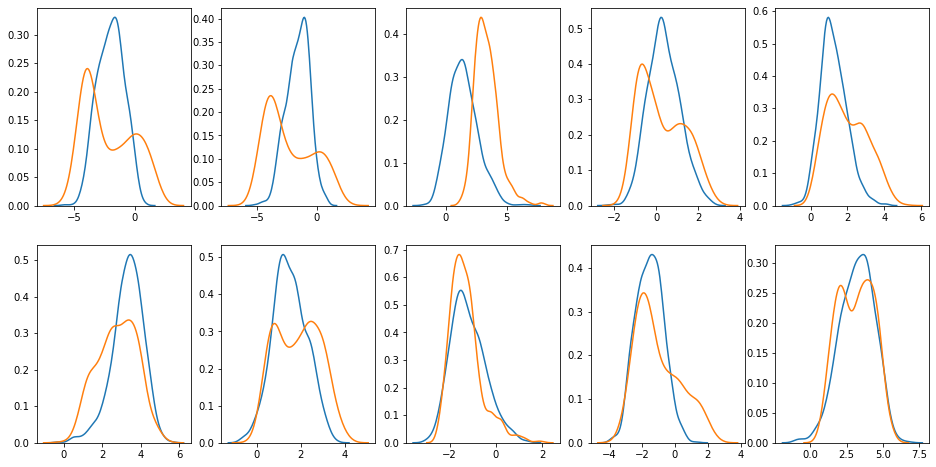

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

setup_seed(80)

path = netG(train0,train0.shape[0],20)
G4 = path[:,-1,:]

print(a(G4,train4))

T4 = train4.detach().cpu().numpy()
G4 = G4.detach().cpu().numpy()

plt.figure(figsize=(16,8))
plt.subplot(2,5,1)
sns.kdeplot(G4[:,0])
sns.kdeplot(T4[:,0])

plt.subplot(2,5,2)
sns.kdeplot(G4[:,1])
sns.kdeplot(T4[:,1])

plt.subplot(2,5,3)
sns.kdeplot(G4[:,2])
sns.kdeplot(T4[:,2])

plt.subplot(2,5,4)
sns.kdeplot(G4[:,3])
sns.kdeplot(T4[:,3])

plt.subplot(2,5,5)
sns.kdeplot(G4[:,4])
sns.kdeplot(T4[:,4])

plt.subplot(2,5,6)
sns.kdeplot(G4[:,5])
sns.kdeplot(T4[:,5])

plt.subplot(2,5,7)
sns.kdeplot(G4[:,6])
sns.kdeplot(T4[:,6])

plt.subplot(2,5,8)
sns.kdeplot(G4[:,7])
sns.kdeplot(T4[:,7])

plt.subplot(2,5,9)
sns.kdeplot(G4[:,8])
sns.kdeplot(T4[:,8])

plt.subplot(2,5,10)
sns.kdeplot(G4[:,9])
sns.kdeplot(T4[:,9])